In [30]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import seaborn as sns
import glob

# Contents

In this tutorial, we will perform segmentation of tumour regions on 3D FLAIR volumes using deep learning. Here are a few concepts explained in this tutorial:

<ul>
    <li>Loading data dynamically within dataloaders.</li>
    <li>Defining the 3D transforms for data augmentation on your own.</li>    
    <li>VGG-FCN model based on VGG-16 architecture (mixture of static_method and nn.Sequential() to define the model).</li>
    <li>Using a learning rate scheduler</li>
    <li>Visualising the saliency of features using gradients</li>
</ul>

First, we check for the type of device available.

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Now we define the hyper-parameters used in the training. 

In [62]:
class Args:
    def __init__(self):
        self.batch_size = 4
        self.log_interval = 10
        self.learning_rate = 1e-3
        self.train_prop = 0.8
        self.val_prop = 0.1
        self.epochs = 25
        self.patience = 12 # For early stopping
args = Args()

Here is where we load the data into 3D arrays rather than 2D array as we did earlier. Also, note that I am collecting training, validation and test file paths in addition to the arrays. We collect the arrays here just for the purpose of plotting and checking the data. In this tutorial, we will pass the file paths directly to data loaders and the loading of 3D volumes happens dynamically within the dataset (unlike the two earlier tutorials) which is memory effiecient. 

In [33]:
import glob
data_files = glob.glob('Week2_data/*.npz')

no_train_samples = int(len(data_files) * args.train_prop)
no_val_samples = int(len(data_files) * args.val_prop)
training_files = data_files[:no_train_samples]
validation_files = data_files[no_train_samples:no_train_samples+no_val_samples]
test_files = data_files[no_train_samples+no_val_samples:]

X = []
y = []
for i in range(len(data_files)):
    obj = np.load(data_files[i])
    X.append(obj['flair'])
    y.append(obj['label'])
    
X = np.array(X)
y = np.array(y)   

Collect the arrays, reshaping them to show the training, validation and test data sizes

In [34]:
print(X.shape, y.shape)

X = np.reshape(X, (-1, 64, 64, 64, 1))
X = X.transpose(0,4,1,2,3)

# Convert the labels to one-hot vector
y = np.reshape(y, (-1, 64, 64, 64, 1))
y = np.concatenate([y==0, y>0], axis=-1).astype(float)
print(y.shape)
y = y.transpose(0,4,1,2,3)
print(y.shape)

trainX = X[:no_train_samples,...]
valX = X[no_train_samples:no_train_samples+no_val_samples,...]
testX = X[no_train_samples+no_val_samples:,...]

trainy = y[:no_train_samples,...]
valy = y[no_train_samples:no_train_samples+no_val_samples,...]
testy = y[no_train_samples+no_val_samples:,...]

print("Training data size: ")
print(trainX.shape, trainy.shape)

print("Validation data size: ")
print(valX.shape, valy.shape)

print("Test data size: ")
print(testX.shape, testy.shape)

(154, 64, 64, 64) (154, 64, 64, 64)
(154, 64, 64, 64, 2)
(154, 2, 64, 64, 64)
Training data size: 
(123, 1, 64, 64, 64) (123, 2, 64, 64, 64)
Validation data size: 
(15, 1, 64, 64, 64) (15, 2, 64, 64, 64)
Test data size: 
(16, 1, 64, 64, 64) (16, 2, 64, 64, 64)


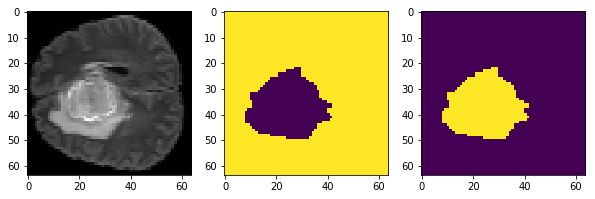

In [35]:
# Plotting the data for a sample training subject

subj=16
slice_no = 13
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.imshow(trainX[subj, 0, :, :, slice_no], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(trainy[subj, 0, :, :, slice_no])
plt.subplot(1,3,3)
plt.imshow(trainy[subj, 1, :, :, slice_no])
plt.show()

## Loading data dynamically within dataloaders

The in-built transforms in torchvision.transforms are designed only for 2D images and they can be applied only on images and not on labels. While it is okay for classification, it will not work for segmentation since whatever transform we apply on images will have to applied to labels as well. Hence, we have a two level challenge: designing transforms for 3D images and applying the _same_ transform for both image and label. 

One of the easier solutions is to create a dictionary of image and label (in dataloaders) and pass this dictionary of images as arguments for the custom-built transforms. I show here how the dictionary of images are read and the transforms are performed.

In [36]:
from torch.utils.data import Dataset

class TumourDatasetwithAug(Dataset):  # Inherit from Dataset class
    """This is a generic class for 3D segmentation datasets.
    :param filename_pairs: a list of tuples in the format (input filename,
                           ground truth filename).
    :param cache: if the data should be cached in memory or not.
    :param transform: transformations to apply.
    """
    def __init__(self, img_paths, transform=None):
        self.data_path = img_paths
        self.transform = transform # This is where you can add augmentations
        
    def __getitem__(self, index):
        """Return the specific index pair volume (input, ground truth).
        :param index: volume index.
        """
        obj = np.load(self.data_path[index]) # Load the image and label from the filepath
        x = np.reshape(obj['flair'], (64, 64, 64, 1))
        y = np.reshape(obj['label'], (64, 64, 64, 1))
        
        # Removing extreme values of intensities (basically add any data preprocessing steps)
        x = x / np.percentile(x, 99.9) 
        x[ x > 1] = 1
        x = x - np.mean(x)
        
        y = np.concatenate([y==0, y>0], axis=-1) # Make one-shot labels
        
        # Create a dictionary of image and label to be passed on to the transform for data augmentation.
        data_dict = {
            'input': x,
            'gt': y
        }

        if self.transform:
            data_dict = self.transform(data_dict) #Apply transforms for augmentation

        return data_dict

    def __len__(self):
        """Return the dataset size."""
        return len(self.data_path)

## Defining the 3D transforms for data augmentation on your own

Now, as seen above, we have a dictionary as input to all our transforms and output an updated dictionary with tranformed image and labels. This section consists of the definition of transform classes. In the next section where I create a dataset instance, note from composed_transform that I apply different transforms (on numpy array) and finally add ToTensor() which converts the numpy array to N x C x X_dim x Y_dim x Z_dim compatible with pytorch, and converts it to the tensor.

Alternatively, you can convert the images/labels to tensors first and apply the transforms on the tensors (note that scipy library functions can't handle tensors, so you need to use transforms available in torch library). 

In [37]:
# Defining a few custom data augmentation transforms for 3D images to be used in with the dataset class 
# in the next section (the one used in the week 1 of the workshop)
import torchvision.transforms.functional as F
from torchvision import transforms
import random
from scipy.ndimage.interpolation import shift
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import rotate, zoom

# The dictionary of images: {'input': input_data, 'gt': label}
# ToTensor() is the final transform to be applied in the composed transforms 
# Hence, we load the numpy array, apply the transform and finally convert them to N x C x X_dim x Y_dim x Z_dim 
# And convert them to tensors.
class ToTensor(object):
    """Convert a PIL image or numpy array to a PyTorch tensor."""

    def __init__(self, labeled=True):
        self.labeled = labeled

    def __call__(self, sample):
        rdict = {}
        input_data = sample['input'] 

        ret_input = input_data.transpose(3,0,1,2) # Pytorch supports N x C x X_dim x Y_dim x Z_dim 
        ret_input = torch.from_numpy(ret_input).float()

        rdict['input'] = ret_input

        if self.labeled:
            gt_data = sample['gt']
            if gt_data is not None:
                ret_gt = gt_data.transpose(3,0,1,2) # Pytorch supports N x C x X_dim x Y_dim x Z_dim 
                ret_gt = torch.from_numpy(ret_gt).float()

                rdict['gt'] = ret_gt
        sample.update(rdict)
        return sample

class RandomRotation3D(object):
    """Make a rotation of the volume's values.
    :param degrees: Maximum rotation's degrees.
    """
    def __init__(self, degrees, axis=0, labeled=True, segment=True):
        self.degrees = degrees
        self.labeled = labeled
        self.segment = segment
        self.order = 0 if self.segment == True else 5

    @staticmethod
    def get_params(degrees): # Get random theta value for rotation
        angle = np.random.uniform(degrees[0], degrees[1])
        return angle

    def __call__(self, sample):
        rdict = {}
        input_data = sample['input']
        if len(sample['input'].shape) != 4: # C x X_dim x Y_dim x Z_dim 
            raise ValueError("Input of RandomRotation3D should be a 4 dimensionnal tensor.") 

        angle = self.get_params(self.degrees)
        input_rotated = np.zeros(input_data.shape, dtype=input_data.dtype)
        gt_data = sample['gt'] if self.labeled else None
        gt_rotated = np.zeros(gt_data.shape, dtype=gt_data.dtype) if self.labeled else None

        # Rotation angle chosen at random and rotation happens only on XY plane for both image and label.
        for sh in range(input_data.shape[2]):
            input_rotated[:,:,sh,0] = rotate(input_data[:,:,sh,0], float(angle), reshape=False, order=self.order, mode='nearest')
            if self.labeled:
                gt_rotated[:,:,sh,0] = rotate(gt_data[:,:,sh,0], float(angle), reshape=False, order=self.order, mode='nearest')
                gt_rotated[:,:,sh,1] = rotate(gt_data[:,:,sh,1], float(angle), reshape=False, order=self.order, mode='nearest')
                gt_rotated = (gt_rotated > 0.6).astype(float)

        # Update the dictionary with transformed image and labels
        rdict['input'] = input_rotated
        if self.labeled: 
            rdict['gt'] = gt_rotated
        sample.update(rdict)
        return sample

class RandomTranslation3D(object):
    """Translate the volume's values.
    :param degrees: maximum of translation values.
    """
    def __init__(self, offsets, axis=0, labeled=True, segment=True):
        self.offsets = offsets
        self.labeled = labeled
        self.segment = segment
        self.order = 0 if self.segment == True else 5

    @staticmethod
    def get_params(offsets): # Get random x and y offset values for translation
        offsetx = np.random.uniform(offsets[0], offsets[1])
        offsety = np.random.uniform(offsets[2], offsets[3])
        return offsetx, offsety
    
    def __call__(self, sample):
        rdict = {}
        input_data = sample['input']
        if len(sample['input'].shape) != 4: # C x X_dim x Y_dim x Z_dim 
            raise ValueError("Input of RandomRotation3D should be a 4 dimensionnal tensor.")

        offsetx, offsety = self.get_params(self.offsets)
        translated_im = np.zeros(input_data.shape)
        translated_im[:,:,:,0] = shift(input_data[:,:,:,0], (offsetx, offsety, 0), order=self.order, mode='nearest')
        if self.labeled:
            gt_data = sample['gt'] 
            translated_label = np.zeros(gt_data.shape)
            translated_label[:,:,:,0] = shift(gt_data[:,:,:,0],(offsetx, offsety, 0), order=self.order, mode='nearest')
            translated_label[:,:,:,1] = shift(gt_data[:,:,:,1],(offsetx, offsety, 0), order=self.order, mode='nearest')
        rdict['input'] = translated_im
        if self.labeled: 
            rdict['gt'] = translated_label
        # Update the dictionary with transformed image and labels
        sample.update(rdict)
        return sample

We create training and validation datasets with the composed transforms for augmentation. Note the ToTensor() transform in the end.

In [38]:
from torch.utils.data import DataLoader

# Compose the transforms you want to perform for augmentation using the definitions above:
# RandomTranslation3D([x_offset_lowerlimit, x_offset_upperlimit, y_offset_lowerlimit, y_offset_upperlimit])
# RandomRotation3D([degrees_lowerlimit, degrees_upperlimit])
# Randomvalues will be chosen between lower and upper limits and the transforms will be applied
composed_transform = transforms.Compose([
            RandomTranslation3D([-10,10,-10,10]), 
            RandomRotation3D([-8,8]),
            ToTensor(),
        ])


train_datadict = TumourDatasetwithAug(training_files, composed_transform)
val_datadict = TumourDatasetwithAug(validation_files, composed_transform)

train_dataloader = DataLoader(train_datadict, batch_size=args.batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_datadict, batch_size=args.batch_size, shuffle=False, num_workers=0)

 ## VGG-FCN model based on VGG-16 architecture
 
 Here, again we consider VGG-16 model (https://arxiv.org/pdf/1409.1556.pdf), instead of classification we need to get segmentation results from the model. Hence, we convert the model into fully convolutional neural network (FCN). For this, we retain the encoder part of the network and convert the fully connected layers into convolutional layers by upsampling the final pooled layer (at the end of encoder) alternating with convolutional layers until it reaches the input image size (similar to the decoder arm of U-Net).
 
 Observe the definition of layers in the model: For encoder, I have retained the nn.Sequential() method of layer definition from previous tutorial, whereas for the convolutional blocks (since it is repeated often) in the decoder, I have made a static method.
 
 Also, look out for the padding values in the decoder part (upsampling and conv part) to adjust the image dimensions to adjust for the size mismatch that occurs during nn.ConvTranspose3d() kernel size.

In [58]:
from collections import OrderedDict

# VGG-FCN (fully convultional layer) architecture as an example model
class FGGFCNSegModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=2, init_features=4):
        super(FGGFCNSegModel, self).__init__()
        self.feature1 = nn.Sequential() # Define the feature extractor for layer1 before 1st pooling layer
        self.feature1.add_module('f_conv1_1', nn.Conv3d(1, init_features, kernel_size=3, padding=1))
        self.feature1.add_module('f_relu_1_1', nn.ReLU(True))
        self.feature1.add_module('f_bn1_1', nn.BatchNorm3d(init_features))
        self.feature1.add_module('f_conv1_2', nn.Conv3d(init_features, init_features, kernel_size=3, padding=1))
        self.feature1.add_module('f_relu_1_2', nn.ReLU(True))
        self.feature1.add_module('f_bn1_2', nn.BatchNorm3d(init_features))
        self.feature1.add_module('f_pool1', nn.MaxPool3d(2))

        self.feature2 = nn.Sequential() # Define the feature extractor for layer1 before 2nd pooling layer  
        self.feature2.add_module('f_conv2_1', nn.Conv3d(init_features, init_features*2, kernel_size=3, padding=1))
        self.feature2.add_module('f_relu_2_1', nn.ReLU(True))
        self.feature2.add_module('f_bn2_1', nn.BatchNorm3d(init_features*2))
        self.feature2.add_module('f_conv2_2', nn.Conv3d(init_features*2, init_features*2, kernel_size=3, padding=1))
        self.feature2.add_module('f_relu_2_2', nn.ReLU(True))
        self.feature2.add_module('f_bn2_2', nn.BatchNorm3d(init_features*2))
        self.feature2.add_module('f_pool2', nn.MaxPool3d(2))

        self.feature3 = nn.Sequential() # Define the feature extractor for layer1 before 3rd pooling layer 
        self.feature3.add_module('f_conv3_1', nn.Conv3d(init_features*2, init_features*2, kernel_size=3, padding=1))
        self.feature3.add_module('f_relu_3_1', nn.ReLU(True))
        self.feature3.add_module('f_bn3_1', nn.BatchNorm3d(init_features*2))
        self.feature3.add_module('f_conv3_2', nn.Conv3d(init_features*2, init_features*2, kernel_size=3, padding=1))
        self.feature3.add_module('f_relu_3_2', nn.ReLU(True))
        self.feature3.add_module('f_bn3_2', nn.BatchNorm3d(init_features*2))
        self.feature3.add_module('f_pool3', nn.MaxPool3d(2))

        self.feature4 = nn.Sequential() # Define the feature extractor for layer1 before 4th pooling layer 
        self.feature4.add_module('f_conv4_1', nn.Conv3d(init_features*2, init_features*4, kernel_size=3, padding=1))
        self.feature4.add_module('f_relu_4_1', nn.ReLU(True))
        self.feature4.add_module('f_bn4_1', nn.BatchNorm3d(init_features*4))
        self.feature4.add_module('f_conv4_2', nn.Conv3d(init_features*4, init_features*4, kernel_size=3, padding=1))
        self.feature4.add_module('f_relu_4_2', nn.ReLU(True))
        self.feature4.add_module('f_bn4_2', nn.BatchNorm3d(init_features*4))
        self.feature4.add_module('f_conv4_3', nn.Conv3d(init_features*4, init_features*4, kernel_size=3, padding=1))
        self.feature4.add_module('f_relu_4_3', nn.ReLU(True))
        self.feature4.add_module('f_bn4_3', nn.BatchNorm3d(init_features*4))
        self.feature4.add_module('f_pool4', nn.MaxPool3d(2))

        self.feature5 = nn.Sequential() # Define the feature extractor for layer1 before 5th pooling layer 
        self.feature5.add_module('f_conv5_1', nn.Conv3d(init_features*4, init_features*4, kernel_size=3, padding=1))
        self.feature5.add_module('f_relu_5_1', nn.ReLU(True))
        self.feature5.add_module('f_bn5_1', nn.BatchNorm3d(init_features*4))
        self.feature5.add_module('f_conv5_2', nn.Conv3d(init_features*4, init_features*4, kernel_size=3, padding=1))
        self.feature5.add_module('f_relu_5_2', nn.ReLU(True))
        self.feature5.add_module('f_bn5_2', nn.BatchNorm3d(init_features*4))
        self.feature5.add_module('f_conv5_3', nn.Conv3d(init_features*4, init_features*4, kernel_size=3, padding=1))
        self.feature5.add_module('f_relu_5_3', nn.ReLU(True))
        self.feature5.add_module('f_bn5_3', nn.BatchNorm3d(init_features*4))
        self.feature5.add_module('f_pool5', nn.MaxPool3d(2))
        
        self.upsample5 = nn.ConvTranspose3d(init_features*4, init_features*4, kernel_size=4, stride=2) # Define the prediction layer at the output of 5th pooling layer
        self.up5pred5 = FGGFCNSegModel._convblock(init_features*4,out_channels,(0,0,0),"32xto16x")
        self.up5pred4 = FGGFCNSegModel._convblock(init_features*4,out_channels,(1,1,1),"16x_sampled")
        
        self.upsample4 = nn.ConvTranspose3d(out_channels, out_channels, kernel_size=4, stride=2) # Define the prediction layer at the output of 5th pooling layer
        self.up4pred4 = FGGFCNSegModel._convblock(out_channels,out_channels,(0,0,0),"16xto8x")
        self.up4pred3 = FGGFCNSegModel._convblock(init_features*2,out_channels,(2,2,2),"8x_sampled1")
        self.up4pred2 = FGGFCNSegModel._convblock(out_channels,out_channels,(1,1,1),"8x_sampled2")
        
        self.upsamplefinal = nn.ConvTranspose3d(out_channels, out_channels, kernel_size=8, stride=4) # Define the prediction layer at the output of 5th pooling layer
        self.up3pred3 = FGGFCNSegModel._convblock(out_channels,out_channels,(2,2,2),"8xtoimgdims")


    def forward(self, x):
        feature1 = self.feature1(x)
        feature1 = self.feature2(feature1)
        feature1 = self.feature3(feature1)
        feature2 = self.feature4(feature1)
        feature3 = self.feature5(feature2)
        feature3 = self.upsample5(feature3)
        feature3 = self.up5pred5(feature3)
        feature2 = self.up5pred4(feature2)
        feature2 = feature2 + feature3
        feature2 = self.upsample4(feature2)
        feature2 = self.up4pred4(feature2)
        feature1 = self.up4pred3(feature1)
        feature1 = self.up4pred2(feature1)
        feature1 = feature1 + feature2
        featureimg = self.upsamplefinal(feature1)
        featureimg = self.up3pred3(featureimg)
        return torch.sigmoid(featureimg)
    
    @staticmethod
    def _convblock(in_channels, features, padding, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv3d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=1,
                            padding=padding,
                        ),
                    ),
                    (name + "relu1", nn.ReLU(inplace=True)),
                ]
            )
        )

### Exercise 4: Can you draw the architecture of the model (with dimensions)?

#### Hint:
The model architecture is similar to Fig. 3 of https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf. Once, we know the end task (classification/segmentation), it is quite easy to convert the models to adapt for the task. To check the dimension of output at a specific layer, try printing the size of the feature in the forward function using .size() attribute.

After defining the model, we now intialise an instance of the model class. We need to move the model to the device (which is CPU, of GPU if available).

In [59]:
seg_model = FGGFCNSegModel(in_channels=1, out_channels=2, init_features=4)
seg_model.to(device=device)

FGGFCNSegModel(
  (feature1): Sequential(
    (f_conv1_1): Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (f_relu_1_1): ReLU(inplace=True)
    (f_bn1_1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (f_conv1_2): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (f_relu_1_2): ReLU(inplace=True)
    (f_bn1_2): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (f_pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (feature2): Sequential(
    (f_conv2_1): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (f_relu_2_1): ReLU(inplace=True)
    (f_bn2_1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (f_conv2_2): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (f_relu_2_2): ReLU(inplace=True)
    (f_bn2_2): BatchNorm3d(8, eps=1e-05, momentu

We define the Dice loss function as the cost function.

In [41]:
from torch.nn.modules.loss import _Loss, _WeightedLoss
import torch.nn.functional
class DiceLoss(_WeightedLoss):
    def __init__(self, weight=None):
        super(DiceLoss, self).__init__(weight)
        self.eps=1e-7

    def forward(self, x, target):
        num_classes = target.shape[1]   # Channels first
        target = target.type(x.type())
        dims = (0,) + tuple(range(2, target.ndimension()))
        intersection = torch.sum(x * target, dims)
        cardinality = torch.sum(x + target, dims)
        dice_loss = (2. * intersection / (cardinality + self.eps)).mean()
        return (1 - dice_loss)

We call Dice loss function as our loss function and move it to the device. And we specify the the parameters to be handled by the optimiser and the optimisation algorithm.

In [60]:
import torch.optim as optim
criterion = DiceLoss()
criterion.to(device=device)
optimizer = optim.Adam(list(seg_model.parameters()), lr=args.learning_rate)#, eps=1e-04)

## Using a learning rate scheduler

So far, we have specified only a fixed learning rate. However, maintaining the same learning rate throughout the training process might be counterproductive. This is due to fact that, in the initial epochs the optimizer is farther from the global minima and hence has to take larger steps (with the initial learning rate specified). However, as the training proceeds over epochs, the optimiser gets closer to the solution (global minima) and hence needs to take finer steps to reach the correct minima (and not get trapped in any spurious local minima due to overshooting). This is the reason why the loss function drops drastically over initial few epochs but decreases slowly over final epochs and finally stabilise at convergence.

Schedulers are used to change the learning rate over epochs by a specified factor which helps to achieve quicker and stable convergence in certain applications. Here I am using a multistep learning rate (multistep LR) scheduler to adjust the learning rate.  To learn about different schedulers, refer to https://pytorch.org/docs/stable/optim.html#. 

There are two parameters in this scheduler: milestones = [a,b,c...] where each value indicates the epoch number to reduce the learning rate, gamma = the factor by which the LR must be reduced. I am reducing the learning rate at 2nd and 5th epoch, each time by the factor of 0.5.

In [63]:
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [2, 5], gamma=0.5, last_epoch=-1)

The Dice overlap measure to get the validation Dice Similary measure.

In [52]:
def determine_dice_metric(pred, target):
    smooth = 1.
    pred_vect = pred.contiguous().view(-1)
    target_vect = target.contiguous().view(-1)
    intersection = (pred_vect * target_vect).sum()
    dice = (2. * intersection + smooth) / (torch.sum(pred_vect) + torch.sum(target_vect) + smooth)
    return dice

We define the early stopping and checkpointing class similar to the previous tutorial.

In [53]:
class EarlyStoppingModelCheckpointing:
    # Early stops the training if the validation loss doesnt improve after a given patience
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, val_acc, best_val_acc, model, epoch, optimizer, loss, PATH):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, val_acc, best_val_acc, model, epoch, optimizer, loss, PATH)
        elif score < self.best_score:
            self.counter += 1
            print('Early Stopping Counter: ', self.counter, '/', self.patience)
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, val_acc, best_val_acc, model, epoch, optimizer, loss, PATH)
            self.counter = 0

    def save_checkpoint(self, val_loss, val_acc, best_val_acc, model, epoch, optimizer, loss, PATH):
            # Saves the model when the validation loss decreases
            if self.verbose:
                print('Validation loss decreased; Saving model ...')
#             # if you want to save only the model weights for the last epoch before early counter activates
#             torch.save(seg_model.state_dict(), MODEL_PATH + 'VGG_FCN_weights_only_finalepoch' + str(epoch) + '.pth')
            # or if you want to save the model weights every N epoch (e.g. N=2) before early counter activates
            if (epoch%2) == 0: 
                torch.save(seg_model.state_dict(),MODEL_PATH + 'VGG_FCN_weights_only_epoch' + str(epoch) + '.pth')
#                 torch.save(seg_model, MODEL_PATH + 'VGG_FCN_full_modelepoch' + str(epoch)) # saving the whole model
#             # or if you want to save the model weights that gives best validation dice meas. value 
#             # before early counter activates
#             if val_acc > best_val_acc:
#                 torch.save(seg_model.state_dict(),MODEL_PATH + 'VGG_FCN_weights_only_bestdice_epoch' + str(epoch) + '.pth')
# #                 torch.save(seg_model, MODEL_PATH + 'VGG_FCN_full_model_bestdice_epoch' + str(epoch))



We now start training! As before, I have saved some weights in case you want to skip training (took about ~1min per epoch on my laptop).

In [64]:
# Training and Validation

from torch.autograd import Variable

MODEL_PATH = 'models/'

# Initialise early stopping
early_stopping = EarlyStoppingModelCheckpointing(args.patience, verbose=False)

loss_store = []
for epoch in range(1, args.epochs+1):
    print('Epoch ', epoch, '/', args.epochs, flush=True)

    # First train 
    total_loss = 0
    val_total_loss = 0
    seg_model.train()      #Put the model in training mode
    batches = 0
    val_dice_accuracy = 0
    best_val_dice_accuracy = 0
    for batch_idx, train_dict in enumerate(train_dataloader):
        data = train_dict['input']
        label = train_dict['gt']
        data = data.to(device=device)
        label = label.to(device=device)
        data = Variable(data)
        label = Variable(label)    # This calls autograd on our data
#         print(data.size())
#         print(data.type(), label.type())
        if list(data.size())[0] == args.batch_size :   # Just being lazy to calc losses
            batches += 1
            # Forward
            optimizer.zero_grad()
            seg_pred = seg_model.forward(data)
            # Calc loss
            train_loss = criterion(seg_pred, label)
            # Backprop the loss
            train_loss.backward()
            optimizer.step()
            total_loss += train_loss
            
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, (batch_idx+1) * len(data), len(train_dataloader.dataset),
                           100. * (batch_idx+1) / len(train_dataloader), train_loss.item()), flush=True)
    
    av_loss = (total_loss / batches).detach().cpu().numpy()   # If you dont detach it keeps the whole model
    print('Training set: Average loss: ',  av_loss, flush=True) 
    
    # Now val
    seg_model.eval()
    batches = 0 
    with torch.no_grad():
        for batch_idx, val_dict in enumerate(val_dataloader):
            data = val_dict['input'].to(device=device)
            label = val_dict['gt'].to(device=device)
            data = Variable(data)
            label = Variable(label)
            if list(data.size())[0] == args.batch_size:
                batches += 1
                pred_seg = seg_model.forward(data)
                loss = criterion(pred_seg, label)
                dice_accuracy = determine_dice_metric(pred_seg, label)
                val_total_loss += loss
                val_dice_accuracy += dice_accuracy 
    val_av_loss = (val_total_loss / batches).detach().cpu().numpy()
    val_dice_accuracy = (val_dice_accuracy / batches).detach().cpu().numpy()
    print('Validation set: Average loss: ',  val_av_loss, flush=True)
    
    # When training and validation is done for each epoch, step up the learning rate scheduler counter
    scheduler.step()
    
    loss_store.append([av_loss, val_av_loss])   # Save the losses so we can plot them
    
    early_stopping(val_av_loss, val_dice_accuracy, best_val_dice_accuracy, seg_model, epoch, optimizer, av_loss, MODEL_PATH)
        
    if val_dice_accuracy > best_val_dice_accuracy:
        best_val_dice_accuracy = val_dice_accuracy
        
    if early_stopping.early_stop:
        loss_store = np.array(loss_store)
#         np.save(LOSS_PATH, loss_store)
        break
        # If you want the system to terminate at this point, you can use sys.exit; very handy when running 
        # codes in clusters
        sys.exit('Patience Reached - Early Stopping Activated')

    torch.cuda.empty_cache()  # Clear memory cache

Epoch  1 / 10
Train Epoch: 1 [4/123 (3%)]	Loss: 0.504468
Train Epoch: 1 [44/123 (35%)]	Loss: 0.480264
Train Epoch: 1 [84/123 (68%)]	Loss: 0.412349
Training set: Average loss:  0.45651397
Validation set: Average loss:  0.44649407
Epoch  2 / 10
Train Epoch: 2 [4/123 (3%)]	Loss: 0.426177
Train Epoch: 2 [44/123 (35%)]	Loss: 0.395638
Train Epoch: 2 [84/123 (68%)]	Loss: 0.419179
Training set: Average loss:  0.41329163
Validation set: Average loss:  0.4233017
Epoch  3 / 10
Train Epoch: 3 [4/123 (3%)]	Loss: 0.425882
Train Epoch: 3 [44/123 (35%)]	Loss: 0.388415
Train Epoch: 3 [84/123 (68%)]	Loss: 0.405958
Training set: Average loss:  0.4035813
Validation set: Average loss:  0.4146966
Epoch  4 / 10
Train Epoch: 4 [4/123 (3%)]	Loss: 0.425821
Train Epoch: 4 [44/123 (35%)]	Loss: 0.397366
Train Epoch: 4 [84/123 (68%)]	Loss: 0.386476
Training set: Average loss:  0.39845753
Validation set: Average loss:  0.41340628
Epoch  5 / 10
Train Epoch: 5 [4/123 (3%)]	Loss: 0.410103
Train Epoch: 5 [44/123 (35%)]	

### Exercise 5: How do we determine the time taken for each epoch?

#### Hint:
Look up time.time()

(2, 10)


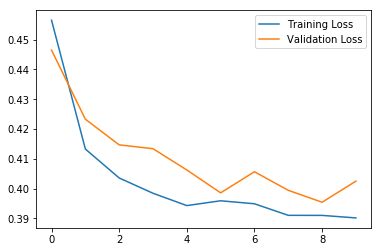

In [65]:
# sns.set()
loss_store = np.array(loss_store).T
print(loss_store.shape)
plt.plot(loss_store[0,:])
plt.plot(loss_store[1,:])
plt.legend(['Training Loss', 'Validation Loss'])

We now get the inference on the test dataset. The test dataset does not require augmentation, however, we define the test dataset with just ToTensor() as our transform.
Get the predictions with .eval() mode of the model and stack the the resulting arrays.

In [66]:
# pretrained_dict = torch.load(MODEL_PATH + 'VGG_FCN_weights_only_epoch5.pth')
# testseg_model = FGGFCNSegModel(in_channels=1, out_channels=2, init_features=4)
# testseg_model.load_state_dict(pretrained_dict)

testseg_model = seg_model

segmentation_results = []
testdata = []
testlabels = []
testseg_model.eval()

test_transform = ToTensor()

test_datadict = TumourDatasetwithAug(test_files, test_transform)
test_dataloader = DataLoader(test_datadict, batch_size=1, shuffle=False, num_workers=0)
with torch.no_grad():
    for test_dict in test_dataloader:
        img = test_dict['input']        
        data = img.to(device=device)
        lab = test_dict['gt']        
        label = lab.to(device=device)
        data = Variable(data)
        label = Variable(label)
        preds = testseg_model.forward(data)
        segmentation_results.append(preds.detach().cpu().numpy())
        testdata.append(img.detach().cpu().numpy())
        testlabels.append(lab.detach().cpu().numpy())

We plot a sample test image, test label with the predicted tumour segmentation. 

(16, 2, 64, 64, 64) (16, 64, 64, 64) (16, 2, 64, 64, 64)


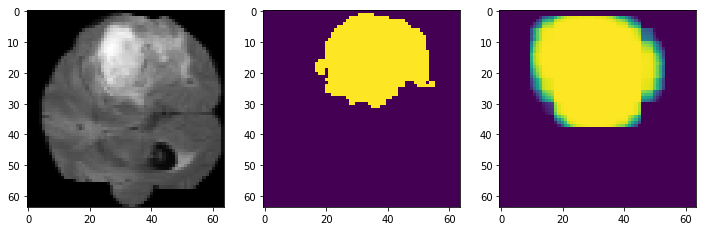

In [70]:
segmentation_results = np.array(segmentation_results).squeeze()
testdata = np.array(testdata).squeeze()
testlabels = np.array(testlabels).squeeze()
print(segmentation_results.shape, testdata.shape, testlabels.shape)
subj = 10
slices = 25
# sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(testdata[subj,:,:,slices], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(testlabels[subj,1,:,:,slices])
plt.subplot(1,3,3)
plt.imshow(segmentation_results[subj,1,:,:,slices])

### Exercise 6: While we obtained a sharper and more refined segmentation with U-Net for hippocampus segmentation (in week 1), we obtained a coarser (and blob-like) segmentation with VGG-FCN, despite having more number of filter channels in the initial layer and training for more epochs. Why is that?

#### Hint:
Learn the importance of the role of skip connections.

## Visualising the saliency of features using gradients

Saliency maps (also known as heatmaps) are quite useful to analyse the locations in the feature maps that would impact the final decision of the model (higher the impact, higher the saliency). Saliency maps are quite useful  analysis tools in the segmentation applications.

Here, we show how to extract saliency maps using _Vanilla Gradient_. Saliency map estimation consists of three steps: 1. Forward pass, 2. Gradient estimation during backward pass and 3. Render the gradient as normalised heatmaps.

If you have saved the model for different epochs, observe how the saliency emerges well in the region of interest with each epoch. 

(16, 64, 64, 64)
(16, 64, 64, 64)


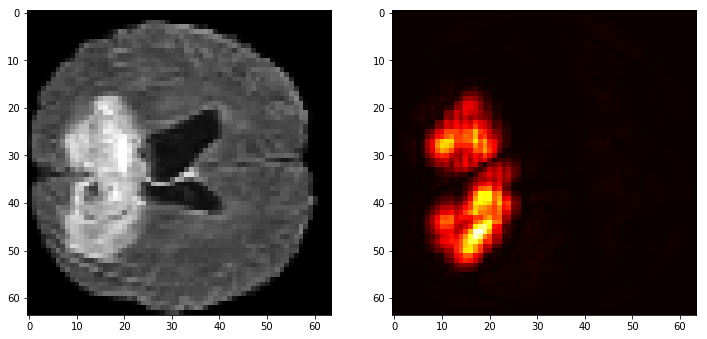

In [72]:
# Getting saliency maps to understand/visualise the features better 
pretrained_dict = torch.load(MODEL_PATH + 'VGG_FCN_weights_only_epoch25.pth')
testseg_model = FGGFCNSegModel(in_channels=1, out_channels=2, init_features=4)
testseg_model.load_state_dict(pretrained_dict)
testseg_model.eval()

images = []
saliency_maps = []
test_transform = ToTensor()

test_datadict = TumourDatasetwithAug(test_files, test_transform)
test_dataloader = DataLoader(test_datadict, batch_size=1, shuffle=False, num_workers=0)

for test_dict in test_dataloader:
    img = test_dict['input']        
    data = img.to(device=device)
    lab = test_dict['gt']        
    label = lab.to(device=device)
    img_var =  torch.autograd.Variable(data, requires_grad=True)

    label = Variable(label, requires_grad=True)
    # Step 1: forward pass
    preds = testseg_model(img_var)    

    loss = criterion(preds, label)
    loss = Variable(loss, requires_grad = True)
    # Step 2: Gradient estimation in backward pass
    loss.backward()
    preds.backward(gradient=label)

    # Step 3: Getting the gradient at the input data node (after backward pass goes from the last layer through
    # all layers to the input node). Determine the max of the gradient to get the saliency maps.
    saliency = np.abs(img_var.grad.data.numpy()[0]).max(axis=0)

    saliency_maps.append(saliency)
    images.append(data.detach().numpy())

saliency_maps = np.array(saliency_maps).squeeze()
images = np.array(images).squeeze()

print(saliency_maps.shape)
print(images.shape)

subj = 12
slices = 25
# sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(images[subj,:,:,slices], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(saliency_maps[subj,:,:,slices], cmap='hot')